# How to generate histograms using the Apache Spark DataFrame API

This provides and example of how to generate frequency histograms using the Spark DataFrame API.  
Disambiguation: we refer here to computing histograms of the DataFrame data, rather than histograms of the columns statistics used by the cost based optimizer.   


In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

# install pyspark if needed
# ! pip install pyspark

# import findspark
# findspark.init("/home/luca/Spark/spark-3.3.0-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("PySpark histograms")
         .master("local[*]")
         .getOrCreate()
        )

## Generate a DataFrame with toy data for demo purposes

In [2]:
num_events = 100
scale = 100
seed = 4242

df = spark.sql(f"select random({seed}) * {scale} as random_value from range({num_events})")

df.show(5)

+------------------+
|      random_value|
+------------------+
|1.4207335464797133|
|   28.332185796207|
|35.723647283875394|
| 31.40224866468887|
|60.990188101279166|
+------------------+
only showing top 5 rows



## Compute the histogram

In [ ]:
# import the computeHistogram function 
# see implementation details at: 
# https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_Histograms/python/sparkhistogram/histogram.py

# requires the package sparkhistogram
! pip install sparkhistogram

from sparkhistogram import computeHistogram


In [4]:
# Compute the histogram using the computeHistogram function

histogram = computeHistogram(df, "random_value", -20, 90, 11)

# Alternative syntax: compute the histogram using transform on the DataFrame
# requires Spark 3.3.0 or higher
# histogram = df.transform(computeHistogram, "random_value", -20, 90, 11)

# this triggers the computation as show() is an action
histogram.show()

+------+-----+-----+
|bucket|value|count|
+------+-----+-----+
|     1|-15.0|    0|
|     2| -5.0|    0|
|     3|  5.0|    6|
|     4| 15.0|   10|
|     5| 25.0|   15|
|     6| 35.0|   12|
|     7| 45.0|    9|
|     8| 55.0|    7|
|     9| 65.0|   10|
|    10| 75.0|   16|
|    11| 85.0|    7|
+------+-----+-----+



In [5]:
# Fetch the histogram data into a Pandas DataFrame for visualization
# At this stage data is reduced to a small number of rows (one row per bin)
# so it can be easily handled by the local machine/driver

# toPandas() is an action and triggers the computation
hist_pandasDF = histogram.toPandas()

hist_pandasDF

,bucket,value,count
0,1,-15.0,0
1,2,-5.0,0
2,3,5.0,6
3,4,15.0,10
4,5,25.0,15
5,6,35.0,12
6,7,45.0,9
7,8,55.0,7
8,9,65.0,10
9,10,75.0,16


In [6]:
# Optionally normalize the event count into a frequency
# dividing by the total number of events
 
hist_pandasDF["frequency"] = hist_pandasDF["count"] / sum(hist_pandasDF["count"]) 
              
hist_pandasDF

,bucket,value,count,frequency
0,1,-15.0,0,0.000000
1,2,-5.0,0,0.000000
2,3,5.0,6,0.065217
3,4,15.0,10,0.108696
4,5,25.0,15,0.163043
5,6,35.0,12,0.130435
6,7,45.0,9,0.097826
7,8,55.0,7,0.076087
8,9,65.0,10,0.108696
9,10,75.0,16,0.173913


## Histogram plotting
The first plot is a histogram with the event counts (number of events per bin).  
The second plot is a histogram of the events frequencies (number of events per bin normalized by the sum of the events).

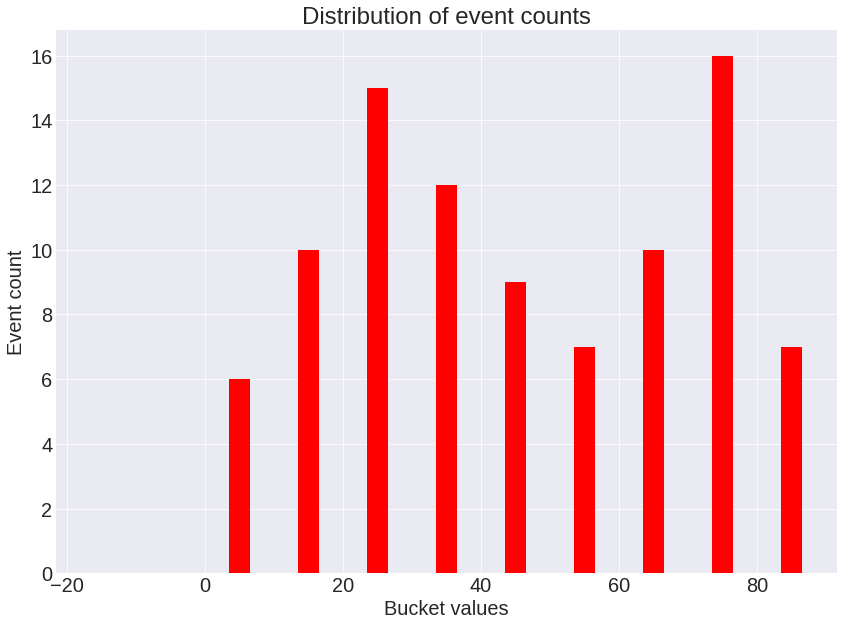

In [7]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["count"]

# bar plot
ax.bar(x, y, width = 3.0, color='red')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event count")
ax.set_title("Distribution of event counts")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

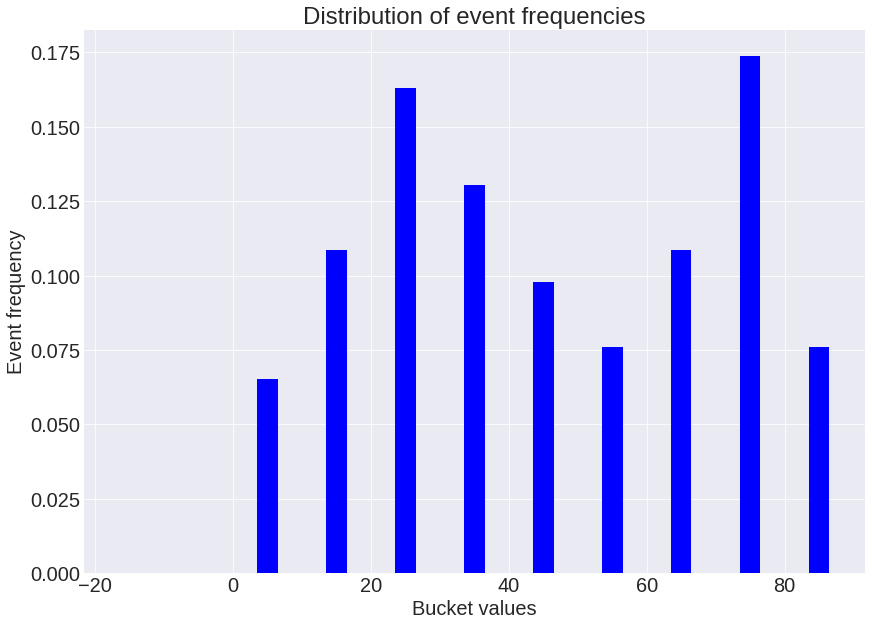

In [8]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["frequency"]

# bar plot
ax.bar(x, y, width = 3.0, color='blue')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event frequency")
ax.set_title("Distribution of event frequencies")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

In [9]:
spark.stop()

##  Note added
Use this to define the computeHistogram function if you cannot pip install sparkhistogram

In [2]:
def computeHistogram(df: "DataFrame", value_col: str, min: int, max: int, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the count/frequecy histogram of a column
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: number of values in the bucket        
    """
    step = (max - min) / bins
    # this will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.sql(f"select id+1 as bucket from range({bins})")
    
    histdf = (df
              .selectExpr(f"width_bucket({value_col}, {min}, {max}, {bins}) as bucket")
              .groupBy("bucket")
              .count()
              .join(df_buckets, "bucket", "right_outer") # add missing buckets and remove buckets out of range
              .selectExpr("bucket", f"{min} + (bucket - 1/2) * {step} as value", # use center value of the buckets
                          "nvl(count, 0) as count") # buckets with no values will have a count of 0
              .orderBy("bucket")
             )
    return histdf
